<h3>Multilayer Perceptron Training for MNIST Classification</h3>

![MLPUrl](https://thumbs.gfycat.com/ForsakenAnchoredIndigowingedparrot-size_restricted.gif "MLP")
>Image source: thumbs.gfycat.com
    
- The MNIST database (Modified National Institute of Standards and Technology database) is a large collection of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger NIST Special Database 3 (digits written by employees of the United States Census Bureau) and Special Database 1 (digits written by high school students) which contain monochrome images of handwritten digits. The digits have been size-normalized and centered in a fixed-size image. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.
> Source: http://yann.lecun.com/exdb/mnist/

<h3>The goal of this project</h3>
        
- In this IPython notebook we will use PyTorch, a deep learning library to build a multilayer perceptron (MLP) which will allow us to accurately classify the hand written digits contained within the MNIST dataset. This work was inspired by [Oliveira et al. (2002)](https://ieeexplore.ieee.org/abstract/document/1046154) and Udacity's "Intro to Deep Learning with PyTorch".

- For those unfamiliar with MLPs, in brief, they are considered as a class of feedforward artificial neural networks and generally consist of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function (e.g., ReLU, tanh, sigmoid etc.) which helps it distinguish data that is not linearly separable. In addition to that, MLPs utilize a supervised learning technique called backpropagation to compute the gradient of the loss function with respect to the weights of the network.

- Unlike CNNs which take tensors as inputs, an MLP only recognizes vectors as inputs and thus it is not capable of understanding the spatial relations between the pixels of a given image. Nevertheless, an MLP classifier can perform exceptionally well on images that have undergone a thorough pre-processing.

<h4>Step 1 - Import Modules and Datasets</h4>

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# batch size
batch_size = 20
# percentage of training set that will be used as a validation set
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



<h4>Step 2 - Visualization of a batch of training data </h4>

<ipython-input-2-4a61cb2317dc>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


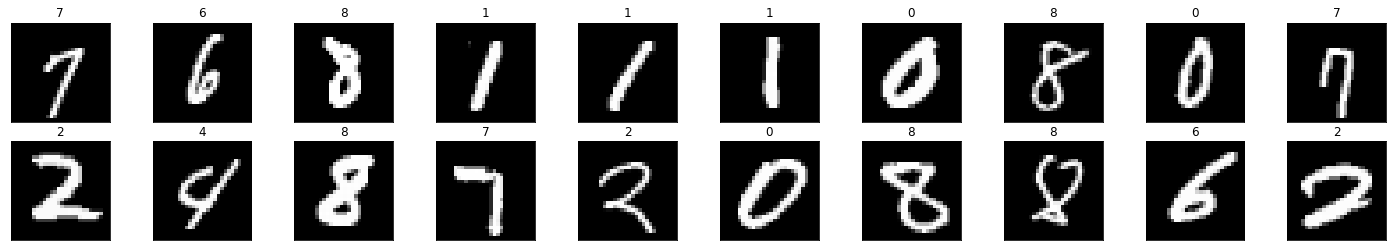

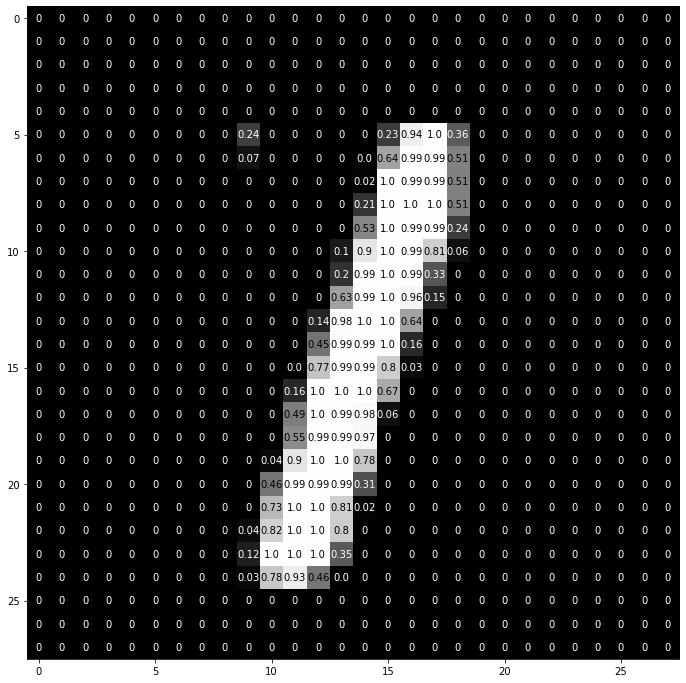

In [2]:
import matplotlib.pyplot as plt

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# View an Image in More Detail
img = np.squeeze(images[3])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

<h4>Step 3.1 - Creating the MLP architecture </h4>

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # Dropout probability
        self.dropout = nn.Dropout(p= 0.2)
        
    def forward(self, x):
        # Flatten the image tensor
        x = x.view(x.shape[0], -1)
        # Set the activation functions
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

<h4>Step 3.2 - Definig the model, criterion and optimizer </h4>

In [4]:
model = Net()
print(model)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


<h4>Step 4 - Training the model </h4>

In [5]:
# Number of epochs to train the model
n_epochs = 25 # suggest training between 20 and 50 epochs

# initalize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep the model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted output by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################        
    model.eval() # prep model for evaluation    
    for data, target in valid_loader:
        # forward pass: compute predicted output by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update validation loss 
        valid_loss += loss.item()
            
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/ len(train_loader)
    valid_loss = valid_loss/ len(valid_loader)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))

Epoch: 1 	Training Loss: 0.299616 	Validation Loss: 0.157586
Epoch: 2 	Training Loss: 0.174531 	Validation Loss: 0.132818
Epoch: 3 	Training Loss: 0.148149 	Validation Loss: 0.119634
Epoch: 4 	Training Loss: 0.131590 	Validation Loss: 0.118749
Epoch: 5 	Training Loss: 0.121496 	Validation Loss: 0.126795
Epoch: 6 	Training Loss: 0.114256 	Validation Loss: 0.128278
Epoch: 7 	Training Loss: 0.106818 	Validation Loss: 0.134564
Epoch: 8 	Training Loss: 0.103004 	Validation Loss: 0.115299
Epoch: 9 	Training Loss: 0.099433 	Validation Loss: 0.136559
Epoch: 10 	Training Loss: 0.095602 	Validation Loss: 0.127829
Epoch: 11 	Training Loss: 0.098925 	Validation Loss: 0.131048
Epoch: 12 	Training Loss: 0.089231 	Validation Loss: 0.139414
Epoch: 13 	Training Loss: 0.090346 	Validation Loss: 0.142474
Epoch: 14 	Training Loss: 0.087352 	Validation Loss: 0.148197
Epoch: 15 	Training Loss: 0.085444 	Validation Loss: 0.149573
Epoch: 16 	Training Loss: 0.081253 	Validation Loss: 0.162405
Epoch: 17 	Traini

<h4>Step 5.1 - Evaluating the model on the test set </h4>

In [6]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

<h4>Step 5.2 - Calculating the average test loss and accuracy per class </h4>

In [28]:
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %1s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.000000

Test Accuracy of 0: 99% (5881/5923)
Test Accuracy of 1: 99% (6714/6742)
Test Accuracy of 2: 99% (5912/5958)
Test Accuracy of 3: 98% (6033/6131)
Test Accuracy of 4: 98% (5763/5842)
Test Accuracy of 5: 98% (5358/5421)
Test Accuracy of 6: 98% (5819/5918)
Test Accuracy of 7: 98% (6201/6265)
Test Accuracy of 8: 97% (5723/5851)
Test Accuracy of 9: 98% (5883/5949)

Test Accuracy (Overall): 98% (59287/60000)


<h4>Step 6 - Visualizing the sample test results </h4>

<ipython-input-19-48bf1d79b703>:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


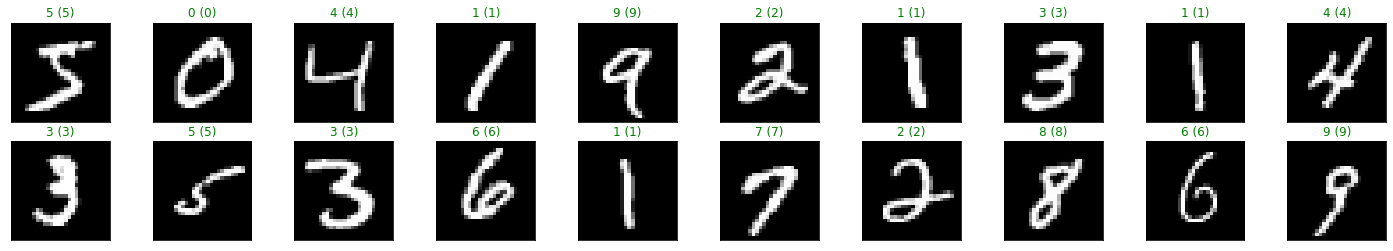

In [19]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

<h4> Final remarks</h4>

The model presented here can achieve an accuracy of 98% on an unseen test set through the following configurations:

- Batch size of 20
- Training and validation split of 0.8 and 0.2, respectively
- Input layer with 784 neurons
- Hidden layer with 256 neurons
- Hidden layer with 64 neurons
- Output layer with 10 neurons
- A ReLU activation function in the intermediate layers 
- A log_softmax activation functin in the output layers
- Learning rate of 0.003
- 25 number of epochs